In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

In [3]:


toload = [ 
    # dict(name="base", id="rv4a-newbase", unnormalise_geom = True, use_xhermes = True),  
    # dict(name="a", id="rv4b-test", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  
    # dict(name="b", id="rv4b-test", unnormalise_geom = True, use_xhermes = True, guard_replace = True),  
    dict(name="rsv", id="rv4c-3reservoirs", unnormalise_geom = True, use_xhermes = True, guard_replace = True),  
]
cs = {}
for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"])


/ssd_scratch/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Unnormalising with xHermes
Replacing guard cells


In [35]:
param = "dy"

d1 = cs["a"].ds[param].values[-5:]
d2 = cs["b"].ds[param].values[-5:]

print("No guard replacement:")
print(d1)
print("\nWith guard replacement:")
print(d2)

print((d1[-3]+d1[-2])/2)
print(d2[-2])

No guard replacement:
[ 1.78264125e-03  1.18892475e-03  5.95208250e-04  1.49175000e-06
 -5.92224750e-04]

With guard replacement:
[ 1.78264125e-03  1.18892475e-03  5.95208250e-04  1.49175000e-06
 -5.92224750e-04]
0.00029835000000000023
1.4917500000097726e-06


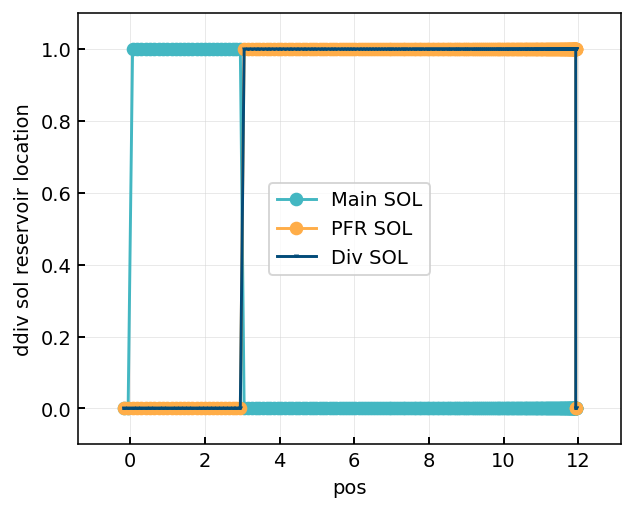

In [4]:
fig, ax = plt.subplots()
ds = cs["test"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)

ds["rsv_main_sol_d"].plot(ax = ax, marker = "o", label = "Main SOL")
ds["rsv_div_pfr_d"].plot(ax = ax, marker = "o", label = "PFR SOL")
ds["rsv_div_sol_d"].plot(ax = ax, marker = "v", ms = 1, label = "Div SOL")

ax.legend()


In [10]:
cs.keys()

dict_keys(['rsv'])

/tmp/ipykernel_259569/850184174.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]


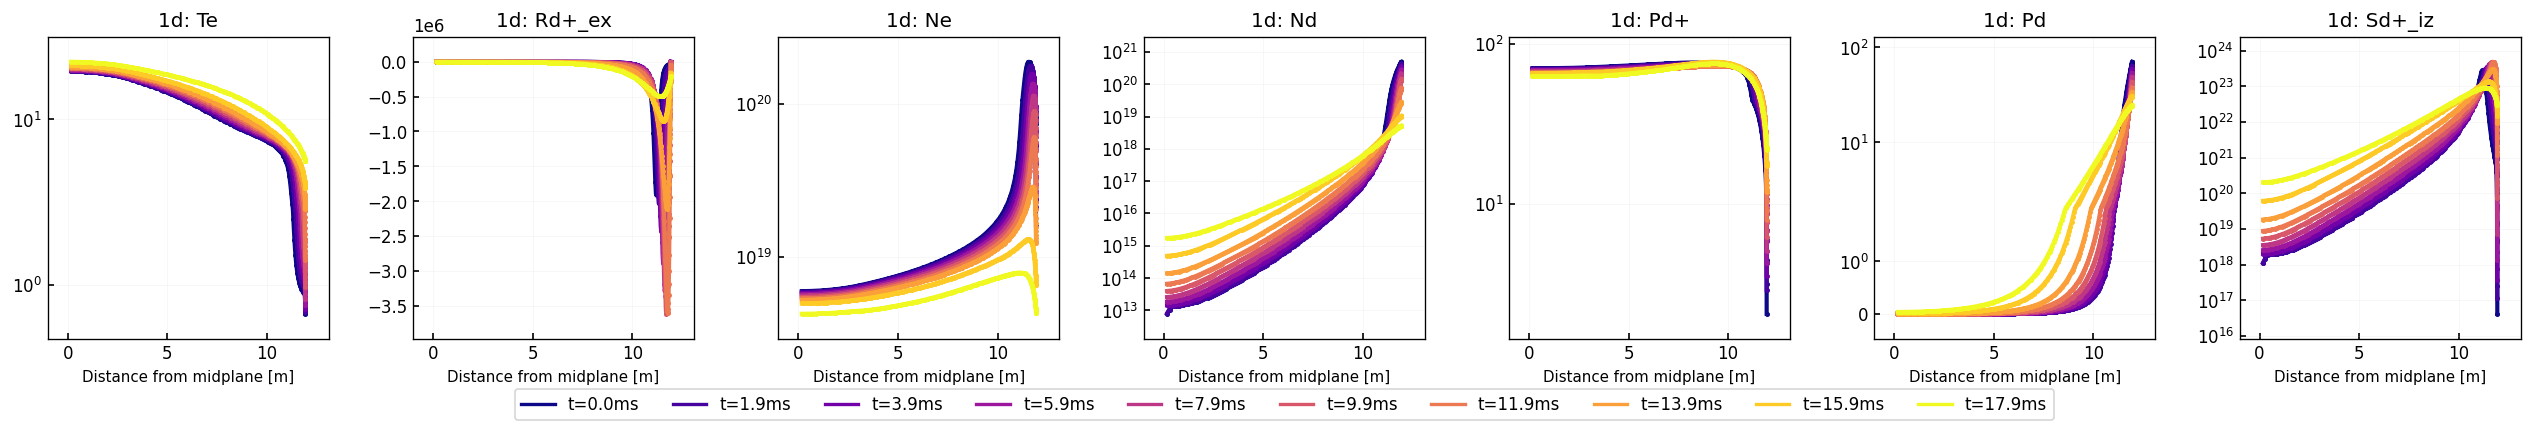

In [4]:

ds = cs["rsv"].ds
# ds = ds2
tlen = ds.dims["t"]
tres = 10
ts = np.linspace(0, tlen-1, tres, dtype = int)
colors = [plt.cm.get_cmap("plasma", tres)(x) for x in range(tres)]

toplot = {}
# for t in [-1]:
for t in ts:
    toplot[f"t={t/10}ms"] = ds.isel(t=t, pos = slice(2,-2))

lineplot(
    toplot,
    clean_guards = False,
    params = ["Te", "Rd+_ex", "Ne", "Nd", "Pd+", "Pd", "Sd+_iz"],
    regions = ["1d"],
    colors = colors
)

In [37]:
dx = xr.open_dataset(r"/ssd_scratch/hcases/reservoir/rv4b-test/BOUT.dmp.1.nc")

In [38]:
dx["dy"].values

array([[ 6.05605747e-02,  5.99668582e-02,  5.93731418e-02,
         5.87794253e-02,  5.81857088e-02,  5.75919923e-02,
         5.69982758e-02,  5.64045592e-02,  5.58108427e-02,
         5.52171262e-02,  5.46234097e-02,  5.40296932e-02,
         5.34359767e-02,  5.28422602e-02,  5.22485437e-02,
         5.16548272e-02,  5.10611107e-02,  5.04673942e-02,
         4.98736777e-02,  4.92799612e-02,  4.86862447e-02,
         4.80925282e-02,  4.74988117e-02,  4.69050952e-02,
         4.63113787e-02,  4.57176622e-02,  4.51239457e-02,
         4.45302293e-02,  4.39365128e-02,  4.33427963e-02,
         4.27490798e-02,  4.21553633e-02,  4.15616468e-02,
         4.09679302e-02,  4.03742137e-02,  3.97804972e-02,
         3.91867807e-02,  3.85930643e-02,  3.79993477e-02,
         3.74056313e-02,  3.68119147e-02,  3.62181982e-02,
         3.56244817e-02,  3.50307653e-02,  3.44370487e-02,
         3.38433322e-02,  3.32496157e-02,  3.26558992e-02,
         3.20621827e-02,  3.14684662e-02,  3.08747497e-0

In [ ]:
vth = np.sqrt(8/np.pi * ds["Te"]/(constants("mass_p")*2))
ds["Te"].plot()

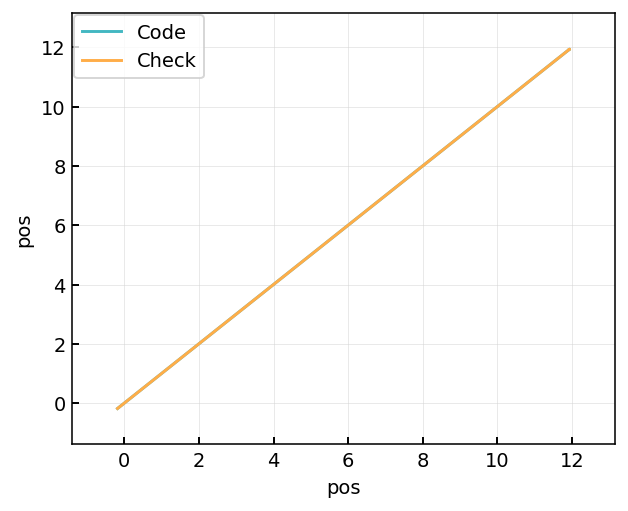

In [5]:
fig, ax = plt.subplots()
ds = cs["test"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)


ds["lpar"].plot(ax = ax, x = "pos", label = "Code")
ds["pos"].plot(ax = ax, x = "pos", label = "Check")
ax.legend()

In [5]:
ds = cs["test"].ds

dy = ds.coords["dy"].values
n = len(dy)
pos = np.zeros(n)
pos[0] = 0.5*dy[0]

for i in range(1,n):
    pos[i] = pos[i-1] + 0.5*dy[i-1] + 0.5*dy[i]
pos -= (pos[1] + pos[2]) / 2

print("Notebook calc")
print(pos[:10])
print("xHermes calc")
print(ds["pos"].values[:10])
print("Hermes-3 calc")
print(ds["ypos"].values[:10])

Notebook calc
[-0.17915619 -0.05952082  0.05952082  0.17796876  0.29582298  0.41308348
  0.52975026  0.64582333  0.76130268  0.87618831]
xHermes calc
[-0.17915619 -0.05952082  0.05952082  0.17796876  0.29582298  0.41308348
  0.52975026  0.64582333  0.76130268  0.87618831]
Hermes-3 calc
[-0.17915619 -0.05952082  0.05952082  0.17796876  0.29582298  0.41308348
  0.52975026  0.64582333  0.76130268  0.87618831]


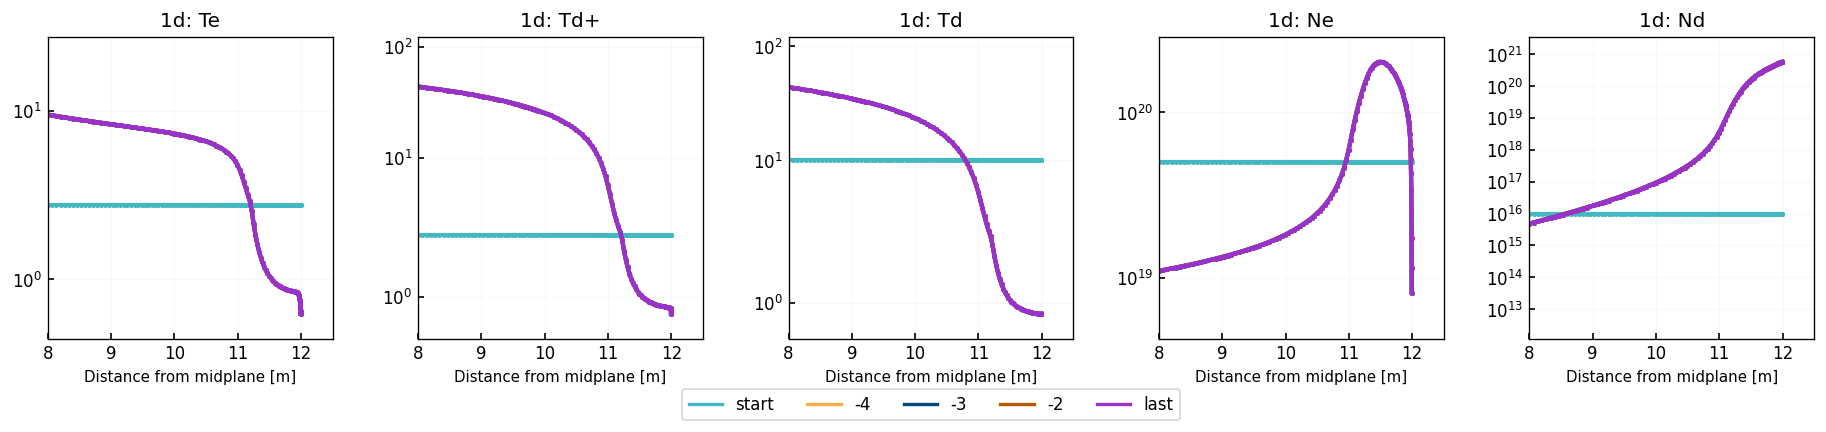

In [17]:
case = "base"
lineplot(
    {
        "start":cs[case].ds.isel(t=0),
        "-4":cs[case].ds.isel(t=-4),
        "-3":cs[case].ds.isel(t=-3),
        "-2":cs[case].ds.isel(t=-2),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Te", "Td+", "Td", "Ne", "Nd"],
    regions = ["1d"],
    xlims=(8,12.5)
)

# Check ypos

In [2]:
cs["test"].ds.metadata

NameError: name 'cs' is not defined

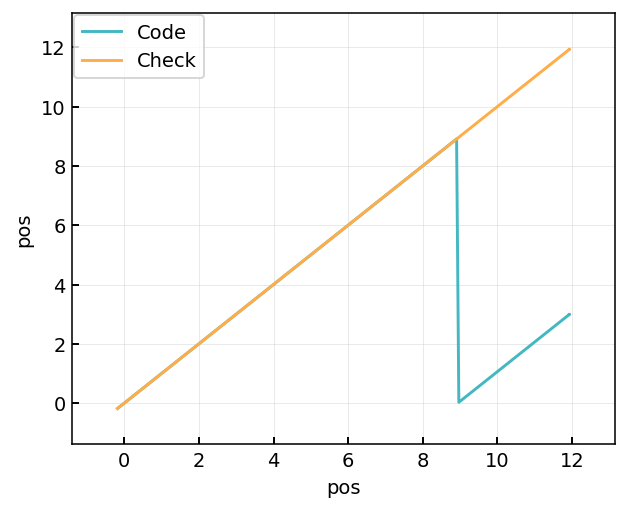

KeyError: 'test'

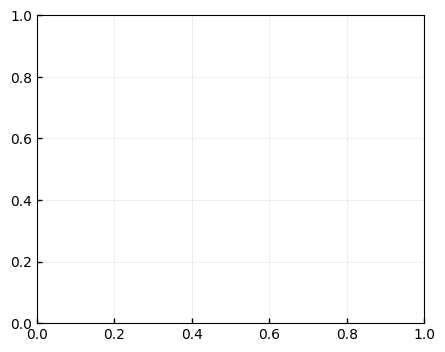

In [6]:
fig, ax = plt.subplots(dpi = 100)


ds = cs["test"].ds.isel(t=-1)
ds["Sd_rsv"].plot(ax = ax, label = "model", lw = 0, marker = "o")

Nd = ds["Nd"]

src = (1e19-Nd)/1e-6
src.plot(ax = ax, label = "calc")
    
ax.set_title("Neutral density")
ax.legend()
ax.set_xlim(10,12)

In [25]:
ds["Nd"].sum("pos").coords

Coordinates:
  * t        (t) float64 0.0 5e+03 1e+04 1.5e+04 ... 4.9e+05 4.95e+05 5e+05

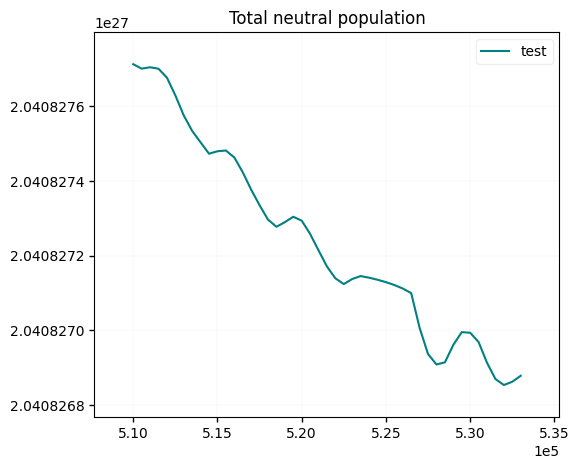

In [6]:
fig, ax = plt.subplots(dpi = 100)


for name in cs.keys():
    
    ds = cs[name].ds.isel(pos = slice(1,-1))
    tot_n = (ds["Nd"] * ds["dv"]).sum("pos")
    ax.plot(ds["t"], tot_n, label = name)
    # tot_n.plot(ax = ax, label = name)
    
ax.set_title("Total neutral population")
ax.legend()

Text(0.5, 1.0, 'Total reservoir transfer')

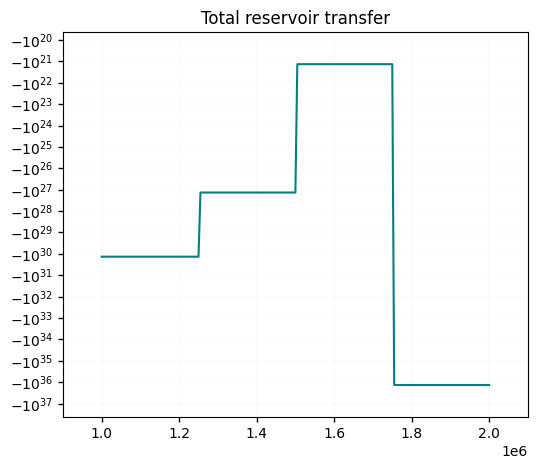

In [4]:
fig, ax = plt.subplots(dpi = 100)



    
ds = cs["increase"].ds.isel(pos = slice(1,-1))

ax.plot(ds["t"], (ds["Sd_rsv"] * ds["dv"]).sum("pos"))
ax.set_yscale("symlog")
# tot_n.plot(ax = ax, label = name)
    
ax.set_title("Total reservoir transfer")

Text(0.5, 1.0, 'Total particle sources')

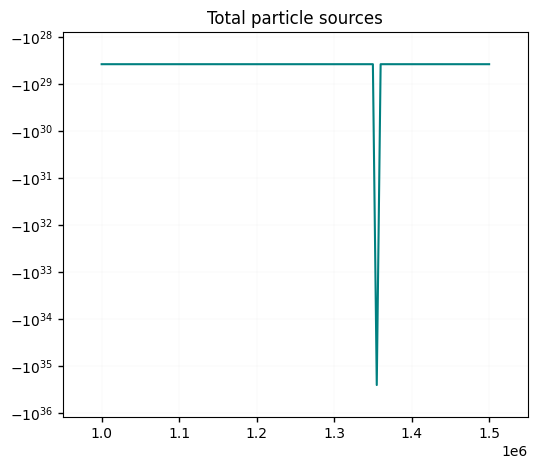

In [9]:
fig, ax = plt.subplots(dpi = 100)

ds = cs["increase"].ds.isel(pos = slice(1,-1))

ax.plot(ds["t"], (ds["SNd"] * ds["dv"]).sum("pos"))
ax.set_yscale("symlog")
# tot_n.plot(ax = ax, label = name)
    
ax.set_title("Total particle sources")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


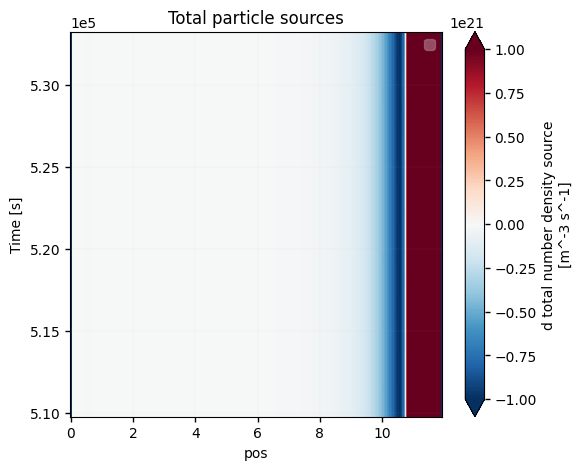

In [31]:
fig, ax = plt.subplots(dpi = 100)

ds = cs["test"].ds.isel(pos = slice(1,-1))

ds["SNd"].plot(ax = ax, robust = True, vmax = 1e21)
# ax.plot(ds["pos"], ds["SNd"], label = "total source")
# ax.plot(ds["pos"], ds["Ed_rsv"], label = "Reservoir source")

# ax.plot(ds["pos"], -ds["Sd+_iz"] + ds["Sd+_rec"], label = "Sum")
# ax.plot(ds["pos"], ds["Sd+_rec"], label = "Rec")
# ax.set_yscale("symlog")
# tot_n.plot(ax = ax, label = name)
    
ax.set_title("Total particle sources")
ax.legend()

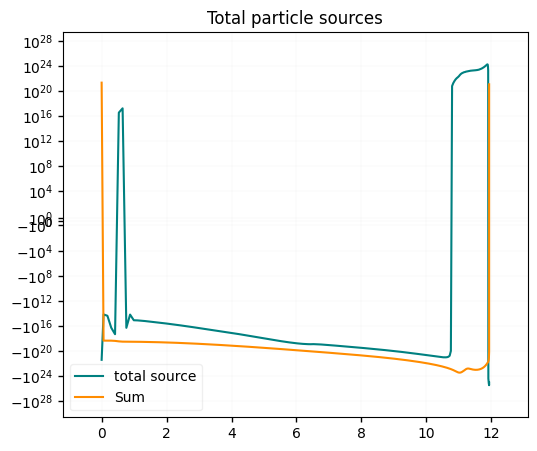

In [13]:
fig, ax = plt.subplots(dpi = 100)

ds = cs["test"].ds.isel(pos = slice(1,-1), t= -1)

ax.plot(ds["pos"], ds["SNd"], label = "total source")
# ax.plot(ds["pos"], ds["Sd_rsv"], label = "Reservoir source")

ax.plot(ds["pos"], -ds["Sd+_iz"] + ds["Sd+_rec"], label = "Sum")
# ax.plot(ds["pos"], ds["Sd+_rec"], label = "Rec")
ax.set_yscale("symlog")
# tot_n.plot(ax = ax, label = name)
    
ax.set_title("Total particle sources")
ax.legend()

In [6]:

def get_var(name):
        return  boutdata.collect(
            name,
            path = db.casepaths["rv2-test"],
            yguards = True,  # Akways with guards to minimise mistakes
            xguards = True,  # Always with guards to minimise mistakes
            strict = True,   # To prevent reading wrong variable by accident
            tind = -1,
            info = False,
            # datafile_cache = cache
        ).squeeze()